In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tarfile
import urllib
import pandas as pd

In [2]:
from utils import load_housing_data, save_fig

housing = load_housing_data()

In [3]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# 연속적인 값은 카테고리로 Grouping
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]) :
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]
    
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing = strat_train_set.copy()

### 상관관계(Correlations) 관찰하기

- 1과 가까우면 양의 상관관계, -1과 가까우면 음의 상관관계, 0은 연관성 낮음

In [4]:
corr_matrix = housing.corr()

In [5]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

#### scatter_matrix 사용해서 상관 관계 확인하기

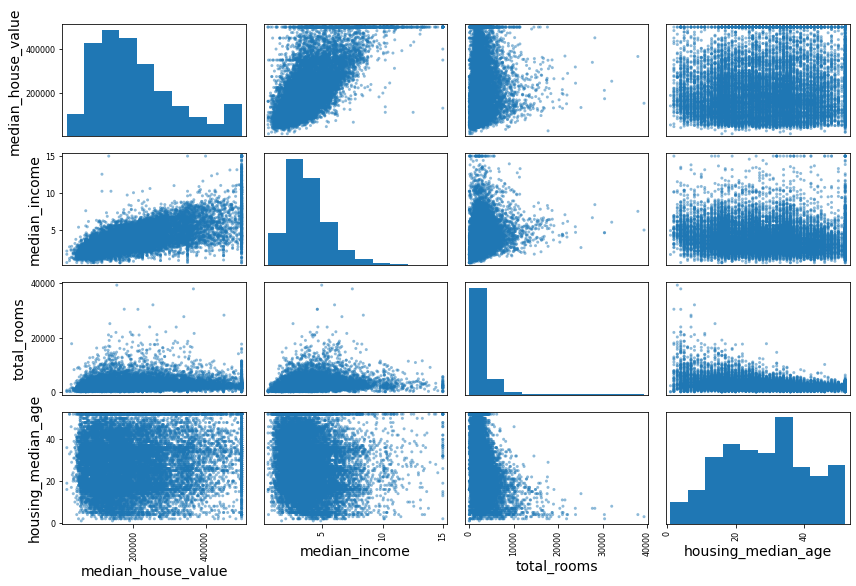

In [6]:
# from pandas.tools.plotting import scatter_matrix  # For older version of pandas
from pandas.plotting import scatter_matrix

# 특성 몇 개만 살펴봄
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

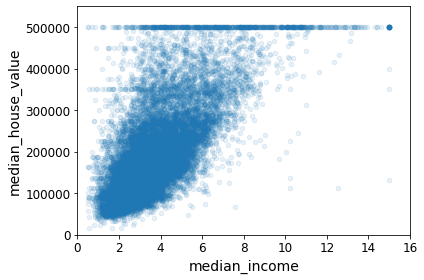

In [7]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

위에서 관찰할 수 있는 사실들?
- 직선으로 된 데이터를 확인할 수 있는데 이러한 데이터에 대해서는 Train Data에서 제외 시키는 것 추천

#### 특성 조합들 실험
- 여러 특성(Feature, Attribute)들의 조합으로 새로운 특성을 정의해 볼 수 있음
- 예를 들자면, 가구당 방 개수, 침대방(Bedroom)의 비율, 가구 당 인원

In [8]:
housing["rooms_per_household"]      = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"]        = housing["total_bedrooms"] / housing["total_rooms"]
housing["popualtion_per_household"] = housing["population"] / housing["households"]

In [9]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
popualtion_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

위에서 관찰할 수 있는 사실들?
- bedrooms_per_room
- rooms_per_household

데이터 탐색 과정은 대부분 한 번으로 끝나지 않고 모델을 만들고 문제점을 분석한 뒤 다시 실행하게 됩니다.

## 4. 머신러닝 알고리즘을 위한 데이터 준비

데이터 준비는 데이터 변환(Data Transformation)과정으로 볼 수 있습니다.  

데이터 수동 변환 vs. 자동 변환(함수 만들기)  

데이터 자동변환의 장점들
- 새로운 데이터에 대한 변환을 손쉽게 재생산(Reproduce)할 수 있습니다.
- 향후에 재사용(Reuse)할 수 있는 라이브러리를 구축하게 됩니다.
- 실제 시스템에서 가공되지 않은 데이터(Raw Data)를 알고리즘에 쉽게 입력으로 사용할 수 있도록 해줍니다.
- 여러 데이터 변환 방법을 쉽게 시도해 볼 수 있습니다.

In [10]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels
housing_labels = strat_train_set["median_house_value"].copy()

### 데이터 정제 (Data Cleaning)
누락된 값(Missing Values) 다루는 방법들
- 해당 구역을 제거(행을 제거)
- 해당 특성을 제거(열을 제거)
- 어떤 값으로 채움(0, 평균, 중간값 등)

In [11]:
housing.isnull().any(axis=1)

17606    False
18632    False
14650    False
3230     False
3555     False
         ...  
6563     False
12053    False
13908    False
11159    False
15775    False
Length: 16512, dtype: bool

In [12]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head() # True if there is a null feature
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3


In [13]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])  # Option 1 : 행을 제거

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat


In [14]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)  # Option 2 : 열을 제거

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN,3


In [15]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # Option 3 : 중간 값으로 채움

In [16]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN,3


#### SimpleImputer 사용하기

In [17]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [18]:
# 중간값은 수치형 특성에만 계산될 수 있기 때문에 텍스트 특성을 제외한 복사본을 생성

In [19]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [20]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [21]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

이제 학습된 Imputer 객체를 사용해 누락된 값을 중간값으로 바꿀 수 있습니다.

In [22]:
X = imputer.transform(housing_num)

In [23]:
X

array([[-121.89  ,   37.29  ,   38.    , ...,  339.    ,    2.7042,
           2.    ],
       [-121.93  ,   37.05  ,   14.    , ...,  113.    ,    6.4214,
           5.    ],
       [-117.2   ,   32.77  ,   31.    , ...,  462.    ,    2.8621,
           2.    ],
       ...,
       [-116.4   ,   34.09  ,    9.    , ...,  765.    ,    3.2723,
           3.    ],
       [-118.01  ,   33.82  ,   31.    , ...,  356.    ,    4.0625,
           3.    ],
       [-122.45  ,   37.77  ,   52.    , ...,  639.    ,    3.575 ,
           3.    ]])

위 X는 Numpy array입니다. 이를 다시 pandas DataFrame으로 되돌릴 수 있습니다.

In [24]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

제대로 채워져 있는 지 확인해봅니다.

In [25]:
sample_incomplete_rows.index.values

array([ 4629,  6068, 17923, 13656, 19252])

In [26]:
housing_num.loc[sample_incomplete_rows.index.values]  ## Missing 값 채우기 전

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,2
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,4
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,4
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,2
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,3


In [27]:
housing_tr.loc[sample_incomplete_rows.index.values]  ## Missing 값 Medain으로 채운 후

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,2.0
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,4.0
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,4.0
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,2.0
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,3.0
